In [1]:
from statistics import mean

import pandas as pd
import numpy as np  # TODO: change isnan to math.isnan
from pyomo.environ import *
import openpyxl

from analysis import restore_plots
from gen_utils import cnf_tools

In [2]:
# Get model configuration
path = "data/cnf_files/restore_cnf_v1.xlsx"
data_handler = cnf_tools.ConfigHandler(path)

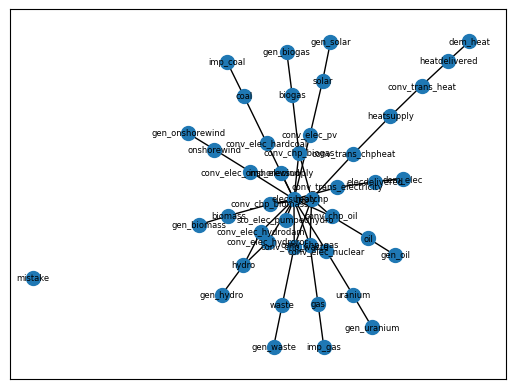

In [3]:
# Show network complexity if there is a connection issue
in_df = data_handler.io_cnf["input_eff"].droplevel(0)
out_df = data_handler.io_cnf["output_eff"].droplevel(0)
in_df["mistake"] = np.nan
out_df["mistake"] = np.nan
restore_plots.plot_io_network(in_df, out_df)

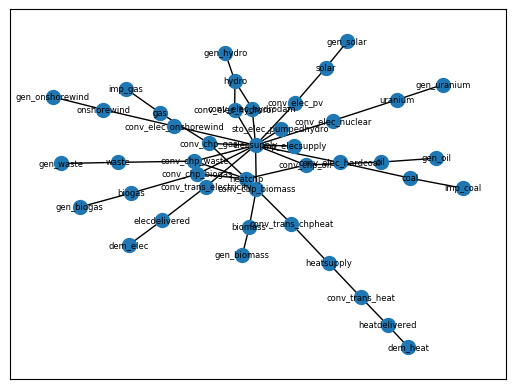

In [4]:
# Show network complexity
in_df = data_handler.io_cnf["input_eff"].droplevel(0)
out_df = data_handler.io_cnf["output_eff"].droplevel(0)
restore_plots.plot_io_network(in_df, out_df)

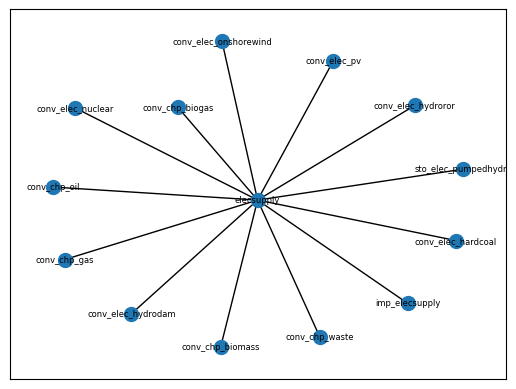

In [5]:
# Show network complexity of regular D-EXPANSE
dxp_tech = ["conv_chp_biogas","conv_chp_biomass","conv_chp_gas","conv_chp_oil","conv_chp_waste",
            "conv_elec_hardcoal","conv_elec_hydrodam","conv_elec_hydroror","conv_elec_nuclear",
            "conv_elec_onshorewind","conv_elec_pv","sto_elec_pumpedhydro", "imp_elecsupply"]
dxp_flow = ["elecsupply"]

dxp_in_df = data_handler.io_cnf["input_eff"].droplevel(0).loc[dxp_tech, dxp_flow]
dxp_out_df = data_handler.io_cnf["output_eff"].droplevel(0).loc[dxp_tech, dxp_flow]
restore_plots.plot_io_network(dxp_in_df, dxp_out_df)

In [6]:
# Configuration
n_days = 2

In [7]:
# Create model sets
# Temporal
years = list(range(1990, 2020))
hours = list(range(n_days*24))  # NOTE: consider separating into day sets and hour sets

# Processes
conversions = set(in_df[in_df.index.str.startswith("conv_")].index)
generations = set(in_df[in_df.index.str.startswith("gen_")].index)
imports = set(in_df[in_df.index.str.startswith("imp_")].index)
storages = set(in_df[in_df.index.str.startswith("sto_")].index)

# Demands
demands = set(in_df[in_df.index.str.startswith("dem_")].index)

processes = conversions | generations | imports | storages
elements = processes | demands

# Flows
flows = set(in_df.columns)

# Combinations
fout_e = cnf_tools.get_flow_element_dict(out_df.loc[~out_df.index.isin(demands)])
fin_e = cnf_tools.get_flow_element_dict(in_df.loc[~in_df.index.isin(generations)])
f_e = cnf_tools.merge_dicts(fout_e, fin_e)

e_fout = cnf_tools.get_flow_element_dict(out_df.loc[~out_df.index.isin(demands)], by_element=True)
e_fin = cnf_tools.get_flow_element_dict(in_df.loc[~in_df.index.isin(generations)], by_element=True)
e_f = cnf_tools.merge_dicts(e_fout, e_fin)

In [8]:
# Sets for special cases
chp_conversions = {i for i in conversions if "_chp_" in i}  # distinct capacity characteristics
vre_conversions = set(c for c in conversions for vre in ["onshorewind", "pv", "offshorewind"] if vre in c)

# Sets

In [9]:
# Initialise model
model = ConcreteModel()

# Indices 1xN
model.Years = Set(initialize=years, ordered=True)
model.Y0 = Set(initialize=[years[0]], ordered=True)
model.Hours = Set(initialize=hours, ordered=True)
model.H0 = Set(initialize=[hours[0]], ordered=True)

model.Convs = Set(initialize=conversions, ordered=False)
model.Gens = Set(initialize=generations, ordered=False)
model.Imps = Set(initialize=imports, ordered=False)
model.Stors = Set(initialize=storages, ordered=False)

model.Dems = Set(initialize=demands, ordered=False)

model.Pros = Set(initialize=processes, ordered=False)

model.Elems = Set(initialize=elements, ordered=False)
model.Flows = Set(initialize=flows, ordered=False)

# Special cases
model.ProsGeneric = Set(initialize=processes-chp_conversions, ordered=False)
model.ConvsVRE = Set(initialize=vre_conversions, ordered=False)


In [10]:
# Cartesian subsets
# See https://github.com/brentertainer/pyomo-tutorials/blob/master/intermediate/05-indexed-sets.ipynb
# Indices FxE with all
model.FiE = Set(within=model.Flows*model.Elems, ordered=False, 
                  initialize={(f, p) for f in flows for p in fin_e[f]})
model.FoE = Set(within=model.Flows*model.Elems, ordered=False, 
                   initialize={(f, p) for f in flows for p in fout_e[f]})
model.FxE = Set(within=model.Flows*model.Elems, ordered=False,
                initialize={(f, p) for f in flows for p in f_e[f]})

# Special cases
model.FoEchp = Set(within=model.Flows*model.Elems, ordered=False, 
                   initialize={(f, p) for f in flows for p in fout_e[f] if p in chp_conversions})
model.FoEgeneric = Set(within=model.Flows*model.Elems, ordered=False, 
                       initialize={(f, p) for f in flows for p in fout_e[f] if p not in chp_conversions})

# Parameters

In [11]:
model.NDAYS = Param(initialize=n_days)
model.TPERIOD = Param(initialize=365/n_days)

# Variables

In [12]:
# Capacity TODO: find a way of eliminating unnecessary capacity variables
model.ctot = Var(model.Pros, model.Years, domain=NonNegativeReals)
model.cnew = Var(model.Pros, model.Years, domain=NonNegativeReals)
model.cret = Var(model.Pros, model.Years, domain=NonNegativeReals)

# Process activity
model.a = Var(model.Gens | model.Convs | model.Stors, model.Years, model.Hours, domain=NonNegativeReals)
model.aimp = Var(model.Imps, model.Years, model.Hours, domain=NonNegativeReals)
model.aexp = Var(model.Imps, model.Years, model.Hours, domain=NonNegativeReals)

# Flows
model.fin = Var(model.FiE, model.Years, model.Hours, domain=NonNegativeReals)
model.fout = Var(model.FoE, model.Years, model.Hours, domain=NonNegativeReals)


# Constraints
## In-out flow

Input - Output balance

In [13]:
def c_inoutbalance(mod, flow, year, hour):
    f_out_of_prev_e = sum(model.fout[f, e, year, hour] for (f, e) in model.FoE if f == flow)
    f_into_next_e = sum(model.fin[f, e, year, hour] for (f, e) in model.FiE if f == flow)
    return  f_out_of_prev_e == f_into_next_e

model.c_inoutbalance = Constraint(model.Flows, model.Years, model.Hours, rule=c_inoutbalance)

In flow efficiency

In [14]:
i_eff = data_handler.ef_stack["input_eff"].to_dict()  # TODO: Consider inverting it for code clarity
i_fac = data_handler.ef_stack["input_factor"].to_dict()
i_rat = data_handler.ef_stack["input_ratio"].to_dict()

def c_flowin(mod, process, year, hour):
    if process in mod.Imps:
        if data_handler.check_process_cnf(process, "enable_export"):
            x = model.aexp[process, year, hour]
        else:
            return Constraint.Skip
    else:
        x = model.a[process, year, hour]
    x = x == sum(model.fin[f,e,year, hour]*i_eff[e, f]*i_fac[e, f]*i_rat[e, f] for (f, e) in model.FiE if e == process)
    return x

model.c_flowin = Constraint(model.Convs | model.Stors | model.Imps , model.Years, model.Hours, rule=c_flowin)

Out flow efficiency

In [15]:
o_eff = data_handler.ef_stack["output_eff"].to_dict()
o_fac = data_handler.ef_stack["output_factor"].to_dict()
o_rat = data_handler.ef_stack["output_ratio"].to_dict()

def c_flowout(mod, flow, element, year, hour):
    if element in mod.Imps:
        if data_handler.check_process_cnf(element, "enable_import"):
            act = mod.aimp[element, year, hour]
        else:
            return Constraint.Skip
    else:
        act = mod.a[element, year, hour]
    return o_eff[element, flow]*o_fac[element, flow]*o_rat[element, flow]*act == mod.fout[flow, element,year, hour]

model.c_flowout = Constraint(model.FoEgeneric, model.Years, model.Hours, rule=c_flowout)

In [16]:
# Special case for CHP
def c_flowoutchp(mod, flow, element, year, hour):
    coeff = o_eff[element, flow]*o_fac[element, flow]*o_rat[element, flow]
    match flow:
        case "elecsupply":
            return coeff*mod.a[element, year, hour] == mod.fout[flow, element, year, hour]
        case "heatchp":
            # Allow heat curtailing
            return coeff*mod.a[element, year, hour] >= mod.fout[flow, element, year, hour]
        case other:
            raise KeyError("Invalid output flow  in 'model.FoEchp' builder:", flow)

model.c_flowoutchp = Constraint(model.FoEchp, model.Years, model.Hours, rule=c_flowoutchp)

Inflow / Outflow maximum share

In [17]:
def c_maxinflowshares(model, flow, process, year, hour):
    if process in model.Imps:
        # Only imports supported, for now
        if data_handler.check_process_cnf(process, "enable_max_inflow_share"):
            max_share = data_handler.get_process_const(process, "max_inflow_share")
            if max_share is not None:
                return model.fin[flow, process, year, hour] <= max_share * sum(model.fin[f, e, year, hour] for (f,e) in model.FiE if f == flow)
            raise ValueError("Max inflow share enabled without value for", process)
            
    return Constraint.Skip

model.c_maxinflowshares = Constraint(model.FiE, model.Years, model.Hours, rule=c_maxinflowshares)

In [18]:
def c_maxoutflowshares(model, flow, process, year, hour):
    if process in model.Imps:
        # Only imports supported, for now
        if data_handler.check_process_cnf(process, "enable_max_outflow_share"):
            max_share = data_handler.get_process_const(process, "max_outflow_share")
            if max_share:
                return model.fout[flow, process, year, hour] <= max_share * sum(model.fout[f, e, year, hour] for (f,e) in model.FoE if f == flow)
            raise ValueError("Max inflow share enabled without value for", process)
        
    return Constraint.Skip

model.c_maxoutflowshares = Constraint(model.FoE, model.Years, model.Hours, rule=c_maxoutflowshares)

## Capacity

Maximum capacity constraint

$$\forall{p \in P, y \in Y} \quad ctot_{p, y} ≤ \text{max\_capacity\_annual}$$

In [19]:
def c_capmax(mod, process, year):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        cap_max = data_handler.get_process_const(process, "max_capacity_annual")
        if cap_max is not None:  
            return mod.ctot[process, year] <= cap_max
        return Constraint.Skip  # Allow infinite capacity
    
    return Constraint.Skip

model.c_capmax = Constraint(model.Pros, model.Years, rule=c_capmax)

Capacity transfer
$$\forall{p \in P, y \in Y \setminus Y_{0}} \quad ctot_{p,y} = ctot_{p,y-1} + cnew_{p,y} - cret_{p,y}$$

In [20]:
def c_captrans(mod, process, year):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        total_capacity = mod.ctot[process, year-1] + mod.cnew[process, year] - mod.cret[process, year]
        return mod.ctot[process, year] == total_capacity
    else:
        return Constraint.Skip
model.c_captrans = Constraint(model.Pros, model.Years-model.Y0, rule=c_captrans)

Capacity retirement

In [21]:
def c_capret(mod, process, year):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        life = data_handler.get_process_const(process, "lifetime")
        if life is not None:
            cnf_retired = data_handler.get_process_value(process, "initial_retired_capacity", year)
            if life <= year - mod.Years.first():
                return mod.cret[process, year] == cnf_retired + mod.cnew[process, year - life]
            return mod.cret[process, year] == cnf_retired
        # Instalments last indefinitely (mostly for electricity trade)
        return mod.cret[process, year] == 0
    return Constraint.Skip
    
model.c_capret = Constraint(model.Pros, model.Years-model.Y0, rule=c_capret)

Buildrate

In [22]:
def c_capbuildrate(mod, process, year):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        buildrate = data_handler.get_process_const(process, "buildrate")
        if buildrate is not None:
            return mod.cnew[process, year] <= buildrate
        raise ValueError("Capacity enabled without buildrate in", process)
    return Constraint.Skip

model.c_capbuildrate = Constraint(model.Pros, model.Years, rule=c_capbuildrate)

## Generation/Activity constraints
Ramping limits

In [23]:
def c_rampup(model, process, year, hour):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        ramp = data_handler.get_process_const(process, "ramp_rate")
        if ramp is not None and ramp < 1:  # No ramping constraint and ramping above 1 are equivalent
            return model.a[process, year, hour] - model.a[process, year, hour-1] <= ramp*model.ctot[process, year]
    return Constraint.Skip

def c_rampdown(model, process, year, hour):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        ramp = data_handler.get_process_const(process, "ramp_rate")
        if ramp is not None and ramp < 1:  # No ramping constraint and ramping above 1 are equivalent
                return model.a[process, year, hour-1] - model.a[process, year, hour] <= ramp*model.ctot[process, year]    
    return Constraint.Skip    

# NOTE: ramping constraints have not been implemented for Imports!
model.c_rampup = Constraint(model.Pros - model.Imps, model.Years, model.Hours-model.H0, rule=c_rampup)
model.c_rampdown = Constraint(model.Pros - model.Imps, model.Years, model.Hours-model.H0, rule=c_rampdown)

Max annual activity

In [24]:
def c_actmax(model, process, year):
    max_act_annual = data_handler.get_process_const(process, "max_activity_annual")
    if max_act_annual is not None:
        return model.TPERIOD * sum(model.a[process, year, h] for h in model.Hours) <= max_act_annual
    return Constraint.Skip  # Allow infinite activity

def c_actmaximport(model, process, year):
    if data_handler.check_process_cnf(process, "enable_import"):
        max_act_annual = data_handler.get_process_const(process, "max_activity_annual")
        if max_act_annual is not None:
            return model.TPERIOD * sum(model.aimp[process, year, h] for h in model.Hours) <= max_act_annual
    return Constraint.Skip  # Allow infinite activity

def c_actmaxexport(model, process, year):
    if data_handler.check_process_cnf(process, "enable_export"):
        max_act_annual = data_handler.get_process_const(process, "max_activity_annual")
        if max_act_annual is not None:
            return model.TPERIOD * sum(model.aexp[process, year, h] for h in model.Hours) <= max_act_annual
    return Constraint.Skip  # Allow infinite activity

model.c_actmax = Constraint(model.Pros-model.Imps, model.Years, rule=c_actmax)
model.c_actmaximport = Constraint(model.Imps, model.Years, rule=c_actmaximport)
model.c_actmaxexport = Constraint(model.Imps, model.Years, rule=c_actmaxexport)

Load Factor capacity limits

In [25]:
# Conversion, generation and storage
def c_lfmin(model, process, year, hour):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        lf_min = data_handler.get_process_value(process, "lf_min", year)
        return lf_min * model.ctot[process, year] <= model.a[process, year, hour]
    return Constraint.Skip

lf_vre_dict = cnf_tools.get_lf_vre("CH")

def c_lfmax(model, process, year, hour):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        if process in model.ConvsVRE:
            lf_max = lf_vre_dict[process][year, hour%24]
        else:
            lf_max = data_handler.get_process_value(process, "lf_max", year)
        return model.a[process, year, hour] <= lf_max * model.ctot[process, year]
    return Constraint.Skip

model.c_lfmin = Constraint(model.Pros-model.Imps, model.Years, model.Hours, rule=c_lfmin)
model.c_lfmax = Constraint(model.Pros-model.Imps, model.Years, model.Hours, rule=c_lfmax)

# Import and Export triangle. Note that it is assumed that lf_min = 0 (NonNegativeReals). Check:
# https://www.wolframalpha.com/input?i=a%2Bb%3C%3D1000++and+a+%3E%3D+0+and+b+%3E%3D+0+
def c_tradelfmax(model, import_id, year, hour):
    if data_handler.check_process_cnf(import_id, "enable_capacity"):
        enable_export = data_handler.check_process_cnf(import_id, "enable_export")
        enable_import = data_handler.check_process_cnf(import_id, "enable_import")
        if enable_export or enable_import:
            imp = model.aimp[import_id, year, hour] if enable_import else 0
            exp = model.aexp[import_id, year, hour] if enable_export else 0
            lf_max = data_handler.get_process_value(import_id, "lf_max", year)
            return imp + exp <= lf_max*model.ctot[import_id, year]
        raise ValueError("Capacity configured, but no export or import enabled for", import_id)
    return Constraint.Skip

def c_tradelfmin(model, import_id, year, hour):
    if data_handler.check_process_cnf(import_id, "enable_capacity"):
        enable_export = data_handler.check_process_cnf(import_id, "enable_export")
        enable_import = data_handler.check_process_cnf(import_id, "enable_import")
        if enable_export or enable_import:
            imp = model.aimp[import_id, year, hour] if enable_import else 0
            exp = model.aexp[import_id, year, hour] if enable_export else 0
            lf_min = data_handler.get_process_value(import_id, "lf_min", year)
            return lf_min*model.ctot[import_id, year] <= imp + exp
        raise ValueError("Capacity configured, but no export or import enabled for", import_id)
    return Constraint.Skip

model.c_tradelfmax = Constraint(model.Imps, model.Years, model.Hours, rule=c_tradelfmax)
model.c_tradelfmin = Constraint(model.Imps, model.Years, model.Hours, rule=c_tradelfmin)

Yearly activity capacity limit, mostly to catch initialisation issues and data collection mistakes...
but is it necessary?

In [27]:
# Conversion, generation and storage
def c_maxannualactcap(model, process, year):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        if process in model.ConvsVRE:
            lf_max_avg = mean([lf_vre_dict[process][year, h%24] for h in model.Hours])
        else:
            lf_max_avg = data_handler.get_process_value(process, "lf_max", year)

        return sum(model.a[process, year, h] for h in model.Hours) <= lf_max_avg * model.NDAYS * model.ctot[process, year]
    return Constraint.Skip

model.c_maxannualactcap = Constraint(model.Pros-model.Imps, model.Years, rule=c_maxannualactcap)

# Trade, the sum of imports and exports
def c_maxannualtradecap(model, process, year):
    if data_handler.check_process_cnf(process, "enable_capacity"):
        enable_export = data_handler.check_process_cnf(process, "enable_export")
        enable_import = data_handler.check_process_cnf(process, "enable_import")
        if enable_export or enable_import:
            total_trade = 0
            if enable_import:
                total_trade += sum(model.aimp[process, year, h] for h in model.Hours)
            if enable_export:
                total_trade += sum(model.aexp[process, year, h] for h in model.Hours)
            lf_max = data_handler.get_process_value(process, "lf_max", year)    
            return total_trade <= model.NDAYS * lf_max * model.ctot[process, year]
        raise ValueError("Capacity configured, but no export or import enabled for", process)
    return Constraint.Skip

model.c_maxannualtradecap = Constraint(model.Imps, model.Years, rule=c_maxannualtradecap)

## Flow constraints

Peak Capacity Requirement

In [28]:
def c_peakcapdem(model, flow, year):
    if data_handler.check_flow_cnf(flow, "enable_peak_capacity_demand"):
        cap_margin = data_handler.get_flow_const(flow, "peak_capacity_margin")
        if cap_margin is not None:
            pk_cap_dem = data_handler.get_flow_value(flow, "peak_capacity_demand", year)
            pk_cap_sys = sum([model.ctot[e, year]*o_eff[e, flow]*o_rat[e, flow]*data_handler.get_process_const(e,"peak_ratio") for f,e in model.FoE if f == flow and e not in model.Imps])
            return pk_cap_sys >= (1+cap_margin)*pk_cap_dem
        raise ValueError("Peak capacity margin configured, but no capacity margin configured in", flow)
    return Constraint.Skip

model.c_peakcapdem = Constraint(model.Flows, model.Years, rule=c_peakcapdem)

Base Capacity Requirement

In [29]:
def c_basecapdem(model, flow, year):
    if data_handler.check_flow_cnf(flow, "enable_base_capacity_demand"):
        base_cap_dem = data_handler.get_flow_value(flow, "base_capacity_demand", year)
        base_cap_sys = sum([model.ctot[e, year]*o_eff[e, flow]*o_rat[e, flow]*data_handler.get_process_value(e,"lf_min", year) for f,e in model.FoE if f == flow and e not in model.Imps])
        imps = sum([model.ctot[e, year]*o_eff[e, flow]*o_rat[e, flow] for f,e in model.FoE if f == flow and e in model.Imps])
        if isinstance(base_cap_sys, int):
            print(f"Warning: base capacity requirement is {base_cap_sys} for {year}. Check LF data.")
            return Constraint.Skip
        x = base_cap_dem >= base_cap_sys - imps 
        return x  # System must be able to go lower than the lowest expected demand
    return Constraint.Skip

model.c_basecapdem = Constraint(model.Flows, model.Years, rule=c_basecapdem)

# Objective Function

# Debugging

In [36]:
model.c_basecapreq.pprint()

c_basecapreq : Size=29, Index=c_basecapreq_index, Active=True
    Key                  : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                           : Upper  : Active
    ('elecsupply', 1991) :  -Inf : 0.19*ctot[conv_chp_gas,1991] + 0.019*ctot[conv_chp_oil,1991] + 0.095*ctot[conv_chp_biogas,1991] + 0.6859999999999999*ctot[conv_elec_nuclear,1991] + 0.32041382915543604*ctot[conv_elec_hydroror,1991] + 0.475*ctot[conv_elec_hardcoal,1991] + 0.17236125945469136*ctot[conv_elec_hydrodam,1991] + 0.0146*ctot[sto_elec_pumpedhydro,1991] + 0.0739249*ctot[conv_chp_waste,1991] + 0.0009000000000000001*ctot[conv_ch

In [32]:
pyomo.util.model_size.build_model_size_report(model)

ModelSizeReport(activated = Bunch(binary_variables = 0, constraints = 151593, continuous_variables = 110597, disjunctions = 0, disjuncts = 0, integer_variables = 0, nonlinear_constraints = 0, variables = 110597), overall = Bunch(binary_variables = 0, constraints = 151593, continuous_variables = 114660, disjunctions = 0, disjuncts = 0, integer_variables = 0, nonlinear_constraints = 0, variables = 114660), warning = Bunch(unassociated_disjuncts = 0))

In [34]:
print(len(model.fin), len(model.fout))

25920 44640


In [33]:
model.wrongin = Var(model.Flows, model.Elems, model.Years, model.Hours)
model.wrongout = Var(model.Flows, model.Elems, model.Years, model.Hours)
print(len(model.wrongin), len(model.wrongout))

604800 604800


In [35]:
pyomo.util.model_size.build_model_size_report(model)

ModelSizeReport(activated = Bunch(binary_variables = 0, constraints = 151593, continuous_variables = 110597, disjunctions = 0, disjuncts = 0, integer_variables = 0, nonlinear_constraints = 0, variables = 110597), overall = Bunch(binary_variables = 0, constraints = 151593, continuous_variables = 1324260, disjunctions = 0, disjuncts = 0, integer_variables = 0, nonlinear_constraints = 0, variables = 1324260), warning = Bunch(unassociated_disjuncts = 0))